In [5]:
import pandas as pd
import numpy as np
from google.cloud import bigquery
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.3f}'.format

bq_client = bigquery.Client()

# 2021 TD
start_date = '2021-01-01'
end_date = '2021-04-18'

sql = """
   WITH table AS (
      SELECT
          DFPI_DATE AS date,
          DFPI_customTargeting,
          DFPzone,
          DFPI_DeviceCategory,
          impressions,
          REGEXP_EXTRACT_ALL(DFPI_customTargeting, r'jt=(.*?);') AS jt_values
      FROM
        `api-project-901373404215.DataMart.v_DFP_Revenue_Type2`
      WHERE
          DFPI_DATE BETWEEN '{}' AND '{}'
          AND REGEXP_EXTRACT_ALL(DFPI_customTargeting, r'jt=(.*?);') IS NOT NULL
    )

    SELECT
        date,
        jt,
        DFPzone AS dfp_zone,
        DFPI_DeviceCategory AS device_category,
        SUM(impressions) AS jt_imps
    FROM (
        SELECT
            date,
            impressions,
            jt,
            DFPzone,
            DFPI_DeviceCategory
        FROM
            table
        CROSS JOIN
            UNNEST(jt_values) AS jt
        WHERE
            jt != '1.1'
        ORDER BY
            DFPI_customTargeting
    )
    GROUP BY
        date,
        jt,
        DFPzone,
        DFPI_DeviceCategory
    """.format(
    start_date,
    end_date
    )

df = bq_client.query(sql).to_dataframe()
df['date'] = pd.to_datetime(df['date'])

print(df.shape)
df.head()

(19998, 5)


,date,jt,dfp_zone,device_category,jt_imps
0,2021-03-02,1,fdc.forbes:article-delta-g-finds-default-standard,Desktop,73
1,2021-03-02,1,fdcmobile:article-amp-masthead-default-standard,Tablet,70
2,2021-03-02,1,fdc.forbes:article-finds-default-standard,Desktop,2274
3,2021-03-02,1,fdcmobile:article-amp-topline-subscriber-standard,Smartphone,5
4,2021-03-02,1,fdc.forbes:article-delta-b-premium-nonsubscrib...,Desktop,6


In [31]:
# Map to the correct device category
device_dict = {
    'Desktop': 'desktop',
    'Tablet': 'desktop',
    'Smartphone': 'mobile'
}

df['device_category'] = df['device_category'].map(device_dict)
df2 = df.loc[df['device_category'].isin(['desktop', 'mobile'])]

# Filter for only c-level
df2 = df2.loc[df2['jt'] == 1]
df2

,date,jt,dfp_zone,device_category,jt_imps
0,2021-03-02,1.000,fdc.forbes:article-delta-g-finds-default-standard,desktop,73
1,2021-03-02,1.000,fdcmobile:article-amp-masthead-default-standard,desktop,70
2,2021-03-02,1.000,fdc.forbes:article-finds-default-standard,desktop,2274
3,2021-03-02,1.000,fdcmobile:article-amp-topline-subscriber-standard,mobile,5
4,2021-03-02,1.000,fdc.forbes:article-delta-b-premium-nonsubscrib...,desktop,6
...,...,...,...,...,...
19993,2021-03-01,1.000,fdcmobile:article-amp-standard-default-standard,mobile,95368
19994,2021-03-01,1.000,fdc.forbes:article-delta-e-standard-default-st...,desktop,2
19995,2021-03-01,1.000,aax.forbes:fdc.forbes-article-standard,desktop,1478
19996,2021-03-01,1.000,fdc.forbes:article-delta-c-masthead-default-st...,desktop,25


In [32]:
# Pivot by device
device = pd.pivot_table(
    df2,
    index='date',
    columns='device_category',
    values='jt_imps',
    aggfunc='sum'
).reset_index()

# Add in a total column
device['total'] = device['desktop'] + device['mobile']

device

device_category,date,desktop,mobile,total
0,2021-01-01,179472,240876,420348
1,2021-01-02,221211,247379,468590
2,2021-01-03,238767,249037,487804
3,2021-01-04,429212,250180,679392
4,2021-01-05,382830,270732,653562
...,...,...,...,...
103,2021-04-14,189037,2197,191234
104,2021-04-15,182685,2480,185165
105,2021-04-16,145539,7038,152577
106,2021-04-17,95961,20798,116759


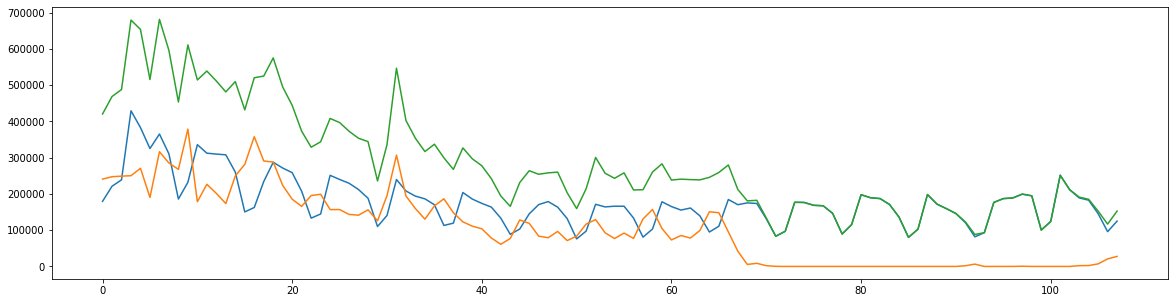

In [33]:
# Plot the impressions by day
plt.figure(figsize=(20,5))
plt.plot(device[['desktop','mobile', 'total']])
plt.show()

In [34]:
# Save to csv
device.to_csv('jt_val_data.csv', index=False)